In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, IterableDataset

from torchvision.datasets import MNIST,CIFAR10
import torchvision.transforms as transforms
from torchvision.models import vgg11

import numpy as np
import matplotlib.pyplot as plt

from lib.server import Server
from lib.client import Client
from lib.data_helper import *
from lib.train_helper import *
from lib.plots import plot_loss_epoch

## Data

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
dataset = CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_dataset = CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
test_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_dataset, valid_dataset = random_split(dataset, [int(len(dataset) * 0.83), int(len(dataset) * 0.17)])

## Network

In [6]:
def toy_net():
    return nn.Sequential(
        nn.Conv2d(3, 64, 3),
        nn.BatchNorm2d(64,track_running_stats=False),
        nn.ReLU(),
        
        nn.Conv2d(64, 64, 3),
        nn.BatchNorm2d(64,track_running_stats=False),
        nn.ReLU(),
        
        nn.Conv2d(64, 128, 3),
        nn.BatchNorm2d(128,track_running_stats=False),
        nn.ReLU(),
        
        nn.MaxPool2d(2, 2),
        
        nn.Conv2d(128, 128, 3),
        nn.BatchNorm2d(128,track_running_stats=False),
        nn.ReLU(),
        
        nn.Conv2d(128, 256, 3),
        nn.BatchNorm2d(256,track_running_stats=False),
        nn.ReLU(),
        
        nn.MaxPool2d(2, 2),
        
        nn.Conv2d(256, 256, 3),
        nn.BatchNorm2d(256,track_running_stats=False),
        nn.ReLU(),
        
        nn.Flatten(),
        nn.Dropout(p=0.5),
        nn.Linear(1024, 10),
    )
toy_net()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (5): ReLU()
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (12): ReLU()
  (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (15): ReLU()
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(

In [7]:
nn.Conv2d(64, 64, 3)(nn.Conv2d(64, 64, 3)(nn.Conv2d(64, 64, 3)(nn.Conv2d(3, 64, 3)(dataset[0][0])))).size()

torch.Size([64, 24, 24])

In [8]:
dict(toy_net().state_dict()).keys()

dict_keys(['0.weight', '0.bias', '1.weight', '1.bias', '3.weight', '3.bias', '4.weight', '4.bias', '6.weight', '6.bias', '7.weight', '7.bias', '10.weight', '10.bias', '11.weight', '11.bias', '13.weight', '13.bias', '14.weight', '14.bias', '17.weight', '17.bias', '18.weight', '18.bias', '22.weight', '22.bias'])

In [9]:
toy_net()(dataset[0][0].unsqueeze(0))

tensor([[ 0.1659, -0.2374,  0.0169,  0.2209,  0.6340, -0.5912,  0.6992,  0.0498,
          0.7561,  0.3160]], grad_fn=<AddmmBackward0>)

## Server-Clients configuration

In [10]:
# underlying module must be of the same class in server & clients
server = Server(toy_net().to(device))
N = 8 # number of clients
partition = partition_by_class(train_dataset)

# for even (iid) split -> set alpha to very big value like 10e8 or very small like 10e-8
# here alpha=0.1 creates very uneven (non-iid) splits
clients = [Client(i,d,toy_net().to(device)) for i,d in enumerate(split(partition,N,alpha=0.1),start=1)]

In [11]:
def run(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optimizer,lr,**kwargs):
    train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size, shuffle=True), device)
    valid_loader = DeviceDataLoader(DataLoader(valid_dataset, batch_size, shuffle=True), device)
    history = []

    server.reset_weights()
    for i in range(rounds):
        print(f'Start Round {i+1} ...')
        server_params = server.net.state_dict()
        clients_params = []
        for client in clients:
                    #train(device, state_dict, epochs, batch_size, opt, lr, **kwargs)
            client.train(device,server_params,epochs,batch_size, optimizer,lr,**kwargs)
        server.merge(clients)
        
        train_loss, train_acc = evaluate(server.net,train_loader)
        dev_loss, dev_acc = evaluate(server.net,valid_loader)
        
        print(f'''After round {i+1} :
        - training loss = {train_loss:.4f}
        - training accuracy = {train_acc:.4f}
        - validation loss = {dev_loss:.4f}
        - validation accuracy = {dev_acc:.4f}
        ''')
        
        history.append((train_loss, dev_loss))
    return history

In [12]:
for c in clients:
    print(c.dataset.__len__())

4547
926
6968
9350
4330
3367
8904
3108


## SGD

In [13]:
rounds = 25
batch_size = 128
epochs = 5
lr = 1e-2

Start Round 1 ...
1: Loss = 0.2921, Accuracy = 0.8854
2: Loss = 0.0971, Accuracy = 0.9717
3: Loss = 0.4582, Accuracy = 0.8522
4: Loss = 0.6248, Accuracy = 0.7959
5: Loss = 0.2228, Accuracy = 0.9486
6: Loss = 0.5130, Accuracy = 0.8376
7: Loss = 0.5955, Accuracy = 0.8179
8: Loss = 0.0615, Accuracy = 0.9903
After round 1 :
        - training loss = 2.8044
        - training accuracy = 0.2273
        - validation loss = 2.8131
        - validation accuracy = 0.2289
        
Start Round 2 ...
1: Loss = 0.2827, Accuracy = 0.8886
2: Loss = 0.1209, Accuracy = 0.9663
3: Loss = 0.3831, Accuracy = 0.8751
4: Loss = 0.5020, Accuracy = 0.8331
5: Loss = 0.1957, Accuracy = 0.9487
6: Loss = 0.4221, Accuracy = 0.8593
7: Loss = 0.4628, Accuracy = 0.8557
8: Loss = 0.0630, Accuracy = 0.9903
After round 2 :
        - training loss = 2.3387
        - training accuracy = 0.2348
        - validation loss = 2.3579
        - validation accuracy = 0.2404
        
Start Round 3 ...
1: Loss = 0.2710, Accuracy = 0.8

4: Loss = 0.0509, Accuracy = 0.9827
5: Loss = 0.0325, Accuracy = 0.9885
6: Loss = 0.0543, Accuracy = 0.9834
7: Loss = 0.0743, Accuracy = 0.9769
8: Loss = 0.0063, Accuracy = 0.9984
After round 18 :
        - training loss = 1.0931
        - training accuracy = 0.7214
        - validation loss = 1.4639
        - validation accuracy = 0.6458
        
Start Round 19 ...
1: Loss = 0.0209, Accuracy = 0.9926
2: Loss = 0.0381, Accuracy = 0.9922
3: Loss = 0.0395, Accuracy = 0.9867
4: Loss = 0.0542, Accuracy = 0.9817
5: Loss = 0.0298, Accuracy = 0.9912
6: Loss = 0.0476, Accuracy = 0.9858
7: Loss = 0.0476, Accuracy = 0.9841
8: Loss = 0.0042, Accuracy = 0.9987
After round 19 :
        - training loss = 1.1497
        - training accuracy = 0.7219
        - validation loss = 1.5502
        - validation accuracy = 0.6464
        
Start Round 20 ...
1: Loss = 0.0158, Accuracy = 0.9948
2: Loss = 0.0204, Accuracy = 0.9922
3: Loss = 0.0446, Accuracy = 0.9853
4: Loss = 0.0588, Accuracy = 0.9798
5: Loss = 

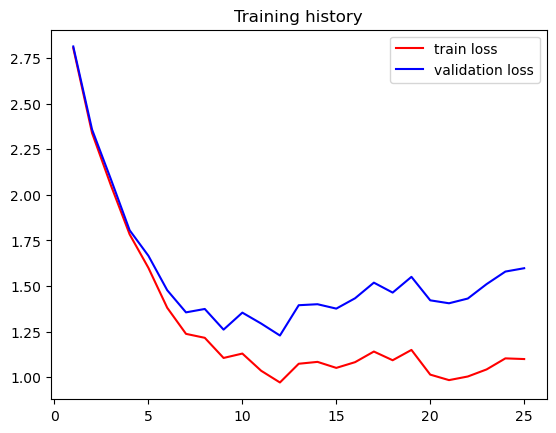

CPU times: user 8min 53s, sys: 515 ms, total: 8min 54s
Wall time: 8min 51s


In [14]:
%%time
history = run(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optim.Adam,lr)
plot_loss_epoch(history)